<a href="https://colab.research.google.com/github/JozefSL/pyNotes/blob/main/pymc3/WellsPerRig.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
from datetime import datetime
from dateutil.relativedelta import relativedelta
from google.colab import drive
import os
import sqlite3
import pymc as pm
import seaborn as sns
import statsmodels.formula.api as smf
from matplotlib import rcParams
import numpy as np
import arviz as az
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.figure_factory as ff
from scipy.stats import gaussian_kde

In [2]:
from google.colab import files
uploaded = files.upload() # rigFile

Saving rigFile.csv to rigFile (1).csv


In [3]:
df = pd.read_csv('rigFile.csv')
df[df['RigID_idx'] == 0].head()

,Unnamed: 0,RigID_idx,wd,wpr
0,0,0,49.0,0.620408
93,93,0,28.0,1.085714
575,575,0,29.0,1.048276
576,576,0,21.0,1.447619
3610,3610,0,43.0,0.706977


In [4]:
allRigs = df['wd'].dropna().values

hist_data = [allRigs]
group_labels = ['allRigs']
fig = ff.create_distplot(hist_data,group_labels, show_hist=False)
fig.update_layout(title_text='allRigs rig-days required to drill a well')
fig.show()

In [5]:
#df['RigID_idx'].values
df['wd'][df['RigID_idx'] == 604].values
#len(df['wd'][df['RigID_idx'] == 17].values)

array([8., 8.])

In [6]:
kde = gaussian_kde(df['wd'][df['RigID_idx'] == 16].values)

In [7]:
newsamples = kde.resample(4)
newsamples

array([[32.61896626,  9.49266404, 27.45748415, 49.80812533]])

In [8]:
rigPermian = df[['RigID_idx','wd']].groupby('RigID_idx').agg(['count']).reset_index()
#rigPermian = rigPermian.reset_index()
rigPermian.set_index('RigID_idx', inplace=True)
rigPermian.columns = rigPermian.columns.droplevel()
rigPermian.head()

,count
RigID_idx,
0,10
1,130
2,9
3,63
4,5


In [9]:
kdeBank=[]
for rigx in rigPermian.index:
     if(len(df['wd'][df['RigID_idx'] == rigx].values))<2:
        kde = gaussian_kde(df['wd'][df['RigID_idx'] == 0].values)
     else:
        try:
          kde = gaussian_kde(df['wd'][df['RigID_idx'] == rigx].values)
        except:
           kde = gaussian_kde(df['wd'][df['RigID_idx'] == 0].values)
     #print(rigx)
     kdeBank.append([rigx, kde])

In [10]:
 kdeBank = pd.DataFrame(kdeBank)
 kdeBank.columns = ['RigID_idx', 'kde']
 kdeBank.set_index('RigID_idx', inplace=True)

In [11]:
kdeBank.head()

,kde
RigID_idx,
0,<scipy.stats._kde.gaussian_kde object at 0x7df...
1,<scipy.stats._kde.gaussian_kde object at 0x7df...
2,<scipy.stats._kde.gaussian_kde object at 0x7df...
3,<scipy.stats._kde.gaussian_kde object at 0x7df...
4,<scipy.stats._kde.gaussian_kde object at 0x7df...


In [12]:
kde = kdeBank.loc[0]['kde']
newsamples = kde.resample(4)
newsamples

array([[23.23767274, 33.17661941, 23.04935772, 45.24173812]])

In [13]:
kdeBank.loc[0]['kde'].resample(4)

array([[31.3441497 , 25.97695506, 32.28343735, 56.37991873]])

In [14]:
len(kdeBank['kde'].values)


791

In [15]:
kde_functions = kdeBank['kde'].values

In [16]:
#kde_functions

In [17]:
# Assign equal weights to each KDE function
weights = np.ones(len(kdeBank['kde'].values)) / len(kdeBank['kde'].values)

In [18]:
combined_kde = lambda x: np.sum(weight * kde_function(x) for weight, kde_function in zip(weights, kde_functions))

In [19]:
# Generate x values for the plot
x_vals = np.linspace(0, 120, 100)

In [20]:
# Evaluate the combined KDE function at x values
y_vals = [combined_kde(x) for x in x_vals]

<ipython-input-18-7fbda9d38e05>:1: DeprecationWarning:

Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.



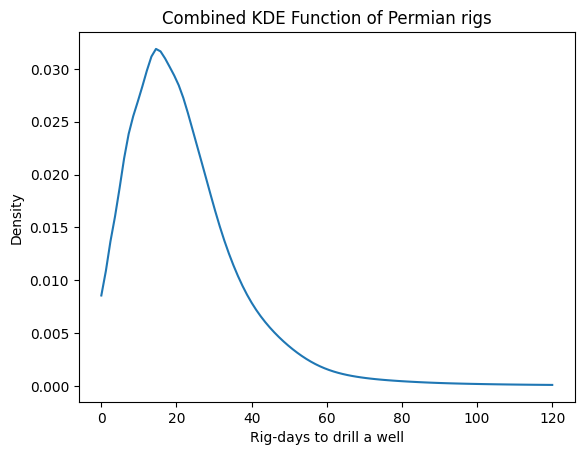

In [21]:
# Plot the combined KDE function
plt.plot(x_vals, y_vals)
plt.xlabel('Rig-days to drill a well')
plt.ylabel('Density')
plt.title('Combined KDE Function of Permian rigs')
plt.show()

In [22]:
kdeBankWPR=[]
for rigx in rigPermian.index:
     if(len(df['wd'][df['RigID_idx'] == rigx].values))<2:
        kde = gaussian_kde(df['wpr'][df['RigID_idx'] == 0].values)
     else:
        try:
          kde = gaussian_kde(df['wpr'][df['RigID_idx'] == rigx].values)
        except:
           kde = gaussian_kde(df['wpr'][df['RigID_idx'] == 0].values)
     #print(rigx)
     kdeBankWPR.append([rigx, kde])

In [23]:
 kdeBankWPR = pd.DataFrame(kdeBankWPR)
 kdeBankWPR.columns = ['RigID_idx', 'kde']
 kdeBankWPR.set_index('RigID_idx', inplace=True)

In [24]:
# Assign equal weights to each KDE function
weightsWPR = np.ones(len(kdeBankWPR['kde'].values)) / len(kdeBankWPR['kde'].values)

In [25]:
#kde_functionsWPR = kdeBankWPR['kde'].values

In [26]:
kde_functionsWPR = kdeBankWPR['kde'].values
combined_kdeWPR = lambda x: np.sum(weight * kde_functionWPR(x) for weight, kde_functionWPR in zip(weightsWPR, kde_functionsWPR))

In [37]:
# Generate x values for the plot
x_valsWPR = np.linspace(0, 4, 40)
# Evaluate the combined KDE function at x values
y_valsWPR = [combined_kdeWPR(x) for x in x_valsWPR]

<ipython-input-26-c8ba387f148e>:1: DeprecationWarning:

Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.



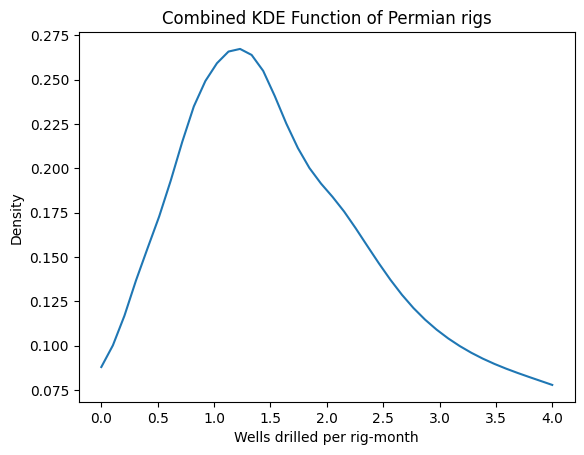

In [30]:
# Plot the combined KDE function
plt.plot(x_valsWPR, y_valsWPR)
plt.xlabel('Wells drilled per rig-month')
plt.ylabel('Density')
plt.title('Combined KDE Function of Permian rigs')
plt.show()

In [ ]:
df6 = df.tail(300)
df6

In [ ]:
rigPermian6 = df6[['RigID_idx','wd']].groupby('RigID_idx').agg(['count']).reset_index()
rigPermian6.set_index('RigID_idx', inplace=True)
rigPermian6.columns = rigPermian6.columns.droplevel()
rigPermian6.head()

In [62]:
kdeJun23=[]
for rigx in rigPermian6.index:
     if(len(df6['wd'][df6['RigID_idx'] == rigx].values))<2:
        kde = gaussian_kde(df6['wpr'][df6['RigID_idx'] == 112].values)
     else:
        try:
          kde = gaussian_kde(df6['wpr'][df6['RigID_idx'] == rigx].values)
        except:
           kde = gaussian_kde(df6['wpr'][df6['RigID_idx'] == 112].values)
     #print(rigx)
     kdeJun23.append([rigx, kde])

In [ ]:
kdeJun23 = pd.DataFrame(kdeJun23)
kdeJun23.columns = ['RigID_idx', 'kde']
kdeJun23.set_index('RigID_idx', inplace=True)
kdeJun23.head()

In [64]:
# Assign equal weights to each KDE function
weightsJun23 = np.ones(len(kdeJun23['kde'].values)) / len(kdeJun23['kde'].values)

In [65]:
kde_functionsJun23 = kdeJun23['kde'].values
combined_kdeJun23 = lambda x: np.sum(weight * kde_function(x) for weight, kde_function in zip(weightsJun23, kde_functionsJun23))

In [66]:
# Generate x values for the plot
x_valsJun23 = np.linspace(0, 4, 40)
# Evaluate the combined KDE function at x values
y_valsJun23 = [combined_kdeJun23(x) for x in x_valsJun23]

<ipython-input-65-de2062ef1200>:2: DeprecationWarning:

Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.



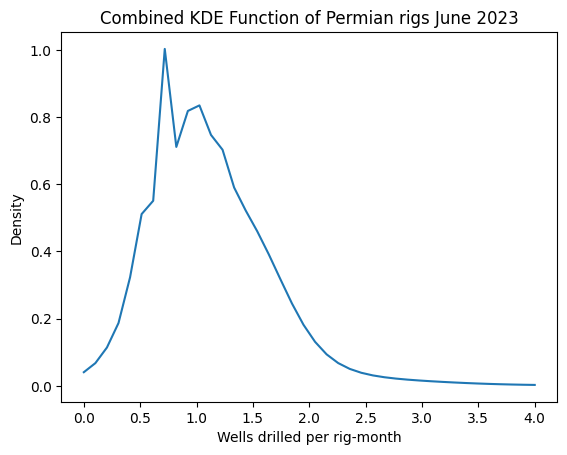

In [67]:
# Plot the combined KDE function
plt.plot(x_valsJun23, y_valsJun23)
plt.xlabel('Wells drilled per rig-month')
plt.ylabel('Density')
plt.title('Combined KDE Function of Permian rigs June 2023')
plt.show()

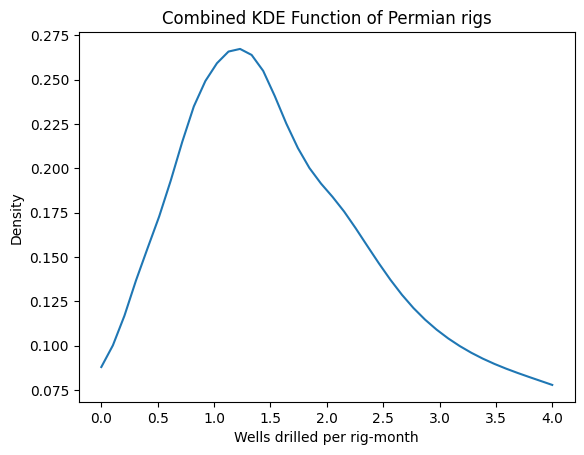

In [68]:
# Plot the combined KDE function
plt.plot(x_valsWPR, y_valsWPR)
plt.xlabel('Wells drilled per rig-month')
plt.ylabel('Density')
plt.title('Combined KDE Function of Permian rigs')
plt.show()

In [ ]:
allRigs = df['wpr'].dropna().values

hist_data = [allRigs]
group_labels = ['allRigs']
fig = ff.create_distplot(hist_data,group_labels, show_hist=False)
fig.update_layout(title_text='allRigs wells per rig-month')
fig.show()

In [ ]:
Rig_idx = df.RigID_idx.values
rig_count = len(df.RigID_idx.unique())

In [ ]:
with pm.Model() as model_r1:
    # Priors
    mu_a = pm.Normal('mu_a', mu=14, sigma=1.5)
    sigma_a = pm.Normal('sigma_a', mu=1.5, sigma=0.5)
    #  intercepts
    a = pm.LogNormal('a', mu=mu_a, sigma=sigma_a, shape=rig_count)

    # Model error
    sigma = pm.Normal('sigma', mu=0.25,  sigma=2)

    mu = a[Rig_idx]
    # Data likelihood
    wd = pm.LogNormal('wd', mu, sigma, observed=df.wd)

    trace_r1 = pm.sample(1000, tune=300, init='auto',chains=1)

In [ ]:
pm.summary(trace_r1).round(2)

In [ ]:
az.plot_trace(trace_r1, var_names=["a"], compact=True);

In [ ]:
pm.plot_trace(trace_r1, figsize=(14,14));

In [ ]:
with pm.Model() as model_r2:
    # Priors
    mu_a = pm.HalfNormal('mu_a', sigma=0.5)
    sigma_a = pm.Normal('sigma_a', mu=0.5, sigma=1.5)
    #  intercepts
    a = pm.LogNormal('a', mu=mu_a, sigma=sigma_a, shape=rig_count)

    # Model error
    sigma = pm.Normal('sigma', mu=0.25,  sigma=1)

    mu = a[Rig_idx]
    # Data likelihood
    wpr = pm.LogNormal('wpr', mu, sigma, observed=df.wpr)

    trace_r2 = pm.sample(1000, tune=300, init='auto',chains=1)

In [ ]:
pm.plot_trace(trace_r2, figsize=(14,14));

In [ ]:
with pm.Model() as model_r3:
    # Priors
    #mu_a = pm.Normal('mu_a', sigma=0.5)
    #sigma_a = pm.Normal('sigma_a', mu=0.5, sigma=1.5)
    #  intercepts
    a = pm.LogNormal('a', mu=16, sigma=0.35, shape=rig_count)

    # Model error
    sigma = pm.Normal('sigma', mu=0.25,  sigma=1)

    mu = a[Rig_idx]
    # Data likelihood
    wd = pm.LogNormal('wd', mu, sigma, observed=df.wd)

    trace_r3 = pm.sample(1000, tune=300, init='auto',chains=1)

In [ ]:
pm.plot_trace(trace_r3, figsize=(14,14));

In [ ]:
with pm.Model() as model_r4:
    # Priors
    #mu_a = pm.Normal('mu_a', sigma=0.5)
    #sigma_a = pm.Normal('sigma_a', mu=0.5, sigma=1.5)
    #  intercepts
    a = pm.LogNormal('a', mu=1.4, sigma=0.35, shape=rig_count)

    # Model error
    sigma = pm.Normal('sigma', mu=0.7,  sigma=1)

    mu = a[Rig_idx]
    # Data likelihood
    wpr = pm.LogNormal('wpr', mu, sigma, observed=df.wpr)

    trace_r4 = pm.sample(1000, tune=300, init='auto',chains=1)

In [ ]:
pm.plot_trace(trace_r4, figsize=(14,14));